## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

#gpu사용
config= tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

In [2]:
print(tf.__version__)

2.3.0


## Load Data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

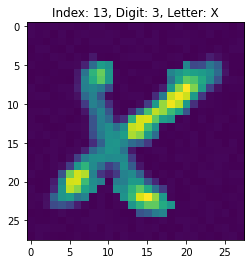

In [4]:
idx = 13
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## Train model

In [5]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_edit=x_train
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [6]:
threshold=140 #임계값
for i in range(0,2048):
    for j in range(0,28):
        for k in range(0,28):
            if(x_edit[i][j][k][0]<=threshold):
                x_edit[i][j][k][0]=0
            else:
                x_edit[i][j][k][0]=255/255

In [7]:
#결과확인
print(x_edit[2046][7])
print(x_train[2046][7])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0.00784314]
 [0.        ]
 [0.02352941]
 [0.07058824]
 [0.07843137]
 [0.23921569]
 [0.26666667]
 [0.43921569]
 [0.83529412]
 [0.89803922]
 [0.92941176]
 [0.92156863]
 [0.91764706]
 [0.92156863]
 [0.88627451]
 [0.88627451]
 [0.94117647]
 [0.95294118]
 [0.93333333]
 [0.70980392]
 [0.21960784]
 [0.        ]
 [0.01568627]
 [0.00784314]
 [0.01176471]
 [0.        ]
 [0.00392157]
 [0.00784314]]


---

In [8]:
x_train1 = np.repeat(x_train, 3, axis=1)
x_train2 = np.repeat(x_train1, 3, axis=2)
x_edit1=np.repeat(x_edit, 3, axis=1)
x_edit2=np.repeat(x_edit1, 3, axis=2)

In [9]:
print(x_train2.shape, x_edit2.shape)

(2048, 84, 84, 1) (2048, 84, 84, 1)


In [10]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    
    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
create_cnn_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 64)       

In [37]:
# 초반 이미지 학습
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=10

#model.fit(x_train, y_train, epochs=50)
history = model.fit(
  datagen.flow(x_edit2, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x_edit2.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/10
128/128 [==============================] - 3s 23ms/step - loss: 3.8085 - accuracy: 0.2876
Epoch 2/10
128/128 [==============================] - 3s 23ms/step - loss: 2.6719 - accuracy: 0.3496
Epoch 3/10
128/128 [==============================] - 3s 23ms/step - loss: 2.4598 - accuracy: 0.3877
Epoch 4/10
128/128 [==============================] - 3s 23ms/step - loss: 2.3651 - accuracy: 0.4224
Epoch 5/10
128/128 [==============================] - 3s 22ms/step - loss: 2.2476 - accuracy: 0.4365
Epoch 6/10
128/128 [==============================] - 3s 23ms/step - loss: 2.1543 - accuracy: 0.4619
Epoch 7/10
128/128 [==============================] - 3s 22ms/step - loss: 2.1247 - accuracy: 0.4751
Epoch 8/10
128/128 [==============================] - 3s 22ms/step - loss: 2.0303 - accuracy: 0.4844
Epoch 9/10
128/128 [==============================] - 3s 22ms/step - loss: 1.9126 - accuracy: 0.5264
Epoch 10/10
128/128 [==============================] - 3s 23ms/step - loss: 1.8739 - accura

In [38]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

#model = create_cnn_model() #앞에거에 이어서 학습

for i in range(0,15):
    epochs=30

    #model.fit(x_train, y_train, epochs=50)

    history = model.fit(
      datagen.flow(x_train2, y_train, batch_size=16),
      epochs=epochs, 
      steps_per_epoch = x_train2.shape[0]//16,
      callbacks=[annealer], 
      verbose = 1 )

    epochs=10

    #model.fit(x_train, y_train, epochs=50)
    history = model.fit(
      datagen.flow(x_edit2, y_train, batch_size=16),
      epochs=epochs, 
      steps_per_epoch = x_edit2.shape[0]//16,
      callbacks=[annealer], 
      verbose = 1
    )



epochs=160

history = model.fit(
  datagen.flow(x_train2, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x_train2.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1 )


Epoch 1/30
128/128 [==============================] - 3s 23ms/step - loss: 1.8759 - accuracy: 0.5435
Epoch 2/30
128/128 [==============================] - 3s 22ms/step - loss: 1.4175 - accuracy: 0.6826
Epoch 3/30
128/128 [==============================] - 3s 22ms/step - loss: 1.2610 - accuracy: 0.7334
Epoch 4/30
128/128 [==============================] - 3s 22ms/step - loss: 1.1474 - accuracy: 0.7637
Epoch 5/30
128/128 [==============================] - 3s 23ms/step - loss: 0.9903 - accuracy: 0.7979
Epoch 6/30
128/128 [==============================] - 3s 21ms/step - loss: 0.9436 - accuracy: 0.8125
Epoch 7/30
128/128 [==============================] - 3s 21ms/step - loss: 0.8681 - accuracy: 0.8291
Epoch 8/30
128/128 [==============================] - 3s 21ms/step - loss: 0.8682 - accuracy: 0.8315
Epoch 9/30
128/128 [==============================] - 3s 21ms/step - loss: 0.7866 - accuracy: 0.8462
Epoch 10/30
128/128 [==============================] - 3s 21ms/step - loss: 0.7141 - accura

128/128 [==============================] - 3s 22ms/step - loss: 1.3914 - accuracy: 0.6079
Epoch 9/10
128/128 [==============================] - 3s 22ms/step - loss: 1.4468 - accuracy: 0.5840
Epoch 10/10
128/128 [==============================] - 3s 22ms/step - loss: 1.3599 - accuracy: 0.6123
Epoch 1/30
128/128 [==============================] - 3s 22ms/step - loss: 1.0570 - accuracy: 0.7295
Epoch 2/30
128/128 [==============================] - 3s 22ms/step - loss: 0.7656 - accuracy: 0.8247
Epoch 3/30
128/128 [==============================] - 3s 22ms/step - loss: 0.8270 - accuracy: 0.8130
Epoch 4/30
128/128 [==============================] - 3s 22ms/step - loss: 0.7923 - accuracy: 0.8315
Epoch 5/30
128/128 [==============================] - 3s 22ms/step - loss: 0.7046 - accuracy: 0.8579
Epoch 6/30
128/128 [==============================] - 3s 22ms/step - loss: 0.6733 - accuracy: 0.8613
Epoch 7/30
128/128 [==============================] - 3s 22ms/step - loss: 0.5712 - accuracy: 0.8896


128/128 [==============================] - 3s 21ms/step - loss: 1.9149 - accuracy: 0.5015
Epoch 2/10
128/128 [==============================] - 3s 21ms/step - loss: 1.7187 - accuracy: 0.5332
Epoch 3/10
128/128 [==============================] - 3s 21ms/step - loss: 1.9239 - accuracy: 0.5073
Epoch 4/10
128/128 [==============================] - 3s 21ms/step - loss: 1.7409 - accuracy: 0.5430
Epoch 5/10
128/128 [==============================] - 3s 21ms/step - loss: 1.6711 - accuracy: 0.5742
Epoch 6/10
128/128 [==============================] - 3s 21ms/step - loss: 1.6019 - accuracy: 0.5874
Epoch 7/10
128/128 [==============================] - 3s 21ms/step - loss: 1.5094 - accuracy: 0.5908
Epoch 8/10
128/128 [==============================] - 3s 21ms/step - loss: 1.4151 - accuracy: 0.6392
Epoch 9/10
128/128 [==============================] - 3s 21ms/step - loss: 1.3967 - accuracy: 0.6147
Epoch 10/10
128/128 [==============================] - 3s 21ms/step - loss: 1.3228 - accuracy: 0.6396


128/128 [==============================] - 3s 21ms/step - loss: 2.0866 - accuracy: 0.4829
Epoch 2/10
128/128 [==============================] - 3s 21ms/step - loss: 1.8482 - accuracy: 0.5371
Epoch 3/10
128/128 [==============================] - 3s 22ms/step - loss: 1.8796 - accuracy: 0.5483
Epoch 4/10
128/128 [==============================] - 3s 21ms/step - loss: 1.6638 - accuracy: 0.5840
Epoch 5/10
128/128 [==============================] - 3s 21ms/step - loss: 1.5864 - accuracy: 0.5986
Epoch 6/10
128/128 [==============================] - 3s 21ms/step - loss: 1.5788 - accuracy: 0.5889
Epoch 7/10
128/128 [==============================] - 3s 21ms/step - loss: 1.5568 - accuracy: 0.5928
Epoch 8/10
128/128 [==============================] - 3s 22ms/step - loss: 1.4380 - accuracy: 0.6191
Epoch 9/10
128/128 [==============================] - 3s 21ms/step - loss: 1.3843 - accuracy: 0.6353
Epoch 10/10
128/128 [==============================] - 3s 21ms/step - loss: 1.3860 - accuracy: 0.6270


128/128 [==============================] - 3s 21ms/step - loss: 0.2337 - accuracy: 0.9692
Epoch 27/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2235 - accuracy: 0.9731
Epoch 28/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2347 - accuracy: 0.9663
Epoch 29/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2106 - accuracy: 0.9722
Epoch 30/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2080 - accuracy: 0.9736
Epoch 1/10
128/128 [==============================] - 3s 21ms/step - loss: 2.1144 - accuracy: 0.4878
Epoch 2/10
128/128 [==============================] - 3s 21ms/step - loss: 1.8122 - accuracy: 0.5571
Epoch 3/10
128/128 [==============================] - 3s 21ms/step - loss: 1.7741 - accuracy: 0.5601
Epoch 4/10
128/128 [==============================] - 3s 21ms/step - loss: 1.6790 - accuracy: 0.5762
Epoch 5/10
128/128 [==============================] - 3s 21ms/step - loss: 1.6154 - accuracy: 0.58

128/128 [==============================] - 3s 21ms/step - loss: 0.2190 - accuracy: 0.9731
Epoch 27/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2091 - accuracy: 0.9785
Epoch 28/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2087 - accuracy: 0.9722
Epoch 29/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2209 - accuracy: 0.9653
Epoch 30/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2112 - accuracy: 0.9697
Epoch 1/10
128/128 [==============================] - 3s 21ms/step - loss: 1.7528 - accuracy: 0.5591
Epoch 2/10
128/128 [==============================] - 3s 21ms/step - loss: 1.6853 - accuracy: 0.5693
Epoch 3/10
128/128 [==============================] - 3s 21ms/step - loss: 1.4741 - accuracy: 0.6206
Epoch 4/10
128/128 [==============================] - 3s 22ms/step - loss: 1.4774 - accuracy: 0.6162
Epoch 5/10
128/128 [==============================] - 3s 21ms/step - loss: 1.4824 - accuracy: 0.61

128/128 [==============================] - 3s 21ms/step - loss: 0.2828 - accuracy: 0.9741
Epoch 22/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2856 - accuracy: 0.9614
Epoch 23/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2739 - accuracy: 0.9707
Epoch 24/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2635 - accuracy: 0.9702
Epoch 25/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2631 - accuracy: 0.9707
Epoch 26/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2751 - accuracy: 0.9678
Epoch 27/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2701 - accuracy: 0.9634
Epoch 28/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2619 - accuracy: 0.9712
Epoch 29/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2500 - accuracy: 0.9722
Epoch 30/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2306 - accuracy:

128/128 [==============================] - 3s 21ms/step - loss: 0.2380 - accuracy: 0.9688
Epoch 22/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2192 - accuracy: 0.9722
Epoch 23/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2096 - accuracy: 0.9780
Epoch 24/30
128/128 [==============================] - 3s 21ms/step - loss: 0.1993 - accuracy: 0.9805
Epoch 25/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2018 - accuracy: 0.9746
Epoch 26/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2006 - accuracy: 0.9731
Epoch 27/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2054 - accuracy: 0.9717
Epoch 28/30
128/128 [==============================] - 3s 21ms/step - loss: 0.2159 - accuracy: 0.9722
Epoch 29/30
128/128 [==============================] - 3s 21ms/step - loss: 0.1881 - accuracy: 0.9751
Epoch 30/30
128/128 [==============================] - 3s 21ms/step - loss: 0.1698 - accuracy:

128/128 [==============================] - 3s 21ms/step - loss: 0.2962 - accuracy: 0.9702
Epoch 14/160
128/128 [==============================] - 3s 21ms/step - loss: 0.2788 - accuracy: 0.9688
Epoch 15/160
128/128 [==============================] - 3s 21ms/step - loss: 0.2945 - accuracy: 0.9629
Epoch 16/160
128/128 [==============================] - 3s 21ms/step - loss: 0.3208 - accuracy: 0.9526
Epoch 17/160
128/128 [==============================] - 3s 21ms/step - loss: 0.3489 - accuracy: 0.9521
Epoch 18/160
128/128 [==============================] - 3s 21ms/step - loss: 0.3044 - accuracy: 0.9648
Epoch 19/160
128/128 [==============================] - 3s 21ms/step - loss: 0.2949 - accuracy: 0.9639
Epoch 20/160
128/128 [==============================] - 3s 21ms/step - loss: 0.2824 - accuracy: 0.9668
Epoch 21/160
128/128 [==============================] - 3s 21ms/step - loss: 0.2794 - accuracy: 0.9644
Epoch 22/160
128/128 [==============================] - 3s 21ms/step - loss: 0.2562 - 

128/128 [==============================] - 3s 21ms/step - loss: 0.1306 - accuracy: 0.9824
Epoch 93/160
128/128 [==============================] - 3s 21ms/step - loss: 0.1356 - accuracy: 0.9844
Epoch 94/160
128/128 [==============================] - 3s 21ms/step - loss: 0.1266 - accuracy: 0.9849 1s
Epoch 95/160
128/128 [==============================] - 3s 21ms/step - loss: 0.1236 - accuracy: 0.9883
Epoch 96/160
128/128 [==============================] - 3s 21ms/step - loss: 0.1234 - accuracy: 0.9873
Epoch 97/160
128/128 [==============================] - 3s 21ms/step - loss: 0.1256 - accuracy: 0.9854
Epoch 98/160
128/128 [==============================] - 3s 21ms/step - loss: 0.1243 - accuracy: 0.9873
Epoch 99/160
128/128 [==============================] - 3s 21ms/step - loss: 0.1341 - accuracy: 0.9805
Epoch 100/160
128/128 [==============================] - 3s 21ms/step - loss: 0.1236 - accuracy: 0.9868
Epoch 101/160
128/128 [==============================] - 3s 21ms/step - loss: 0.12

## Predict

In [39]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_t_edit=x_test
x_test = x_test/255

In [40]:
x_test1 = np.repeat(x_test, 3, axis=1)
x_test2 = np.repeat(x_test1, 3, axis=2)

In [41]:
submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test2), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
5,2054,7
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [42]:
submission.to_csv('fine-tuning10_30 15번반복_160.csv', index=False)

---

In [81]:
threshold=140 #임계값
for i in range(0,20480):
    if(i%3000==0):
        print(i)
    for j in range(0,28):
        for k in range(0,28): 
            if(x_t_edit[i][j][k][0]<=threshold):
                x_t_edit[i][j][k][0]=0
            else:
                x_t_edit[i][j][k][0]=255/255

0
3000
6000
9000
12000
15000
18000


In [82]:
x_t_edit1 = np.repeat(x_t_edit, 3, axis=1)
x_t_edit2 = np.repeat(x_t_edit1, 3, axis=2)

In [83]:
submission2 = pd.read_csv('data/submission.csv')
submission2['digit'] = np.argmax(model.predict(x_t_edit2), axis=1)
submission2.head(50)

,id,digit
0,2049,2
1,2050,8
2,2051,2
3,2052,8
4,2053,8
5,2054,8
6,2055,8
7,2056,2
8,2057,2
9,2058,8


In [84]:
#head만봐도 정확도가 너무 안좋아서 따로 저장 안하는게 나을듯?
submission2.to_csv('두번 이어서 훈련_이진화otest.csv', index=False)